# Twitter Spam Learning: Classifer
## CSCE 670 Spring 2018, Course Project
### By: Yue Yang (625008110)

There will be series of notebooks outlining how we train our models. This one looks into [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree_learning) and [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) in details.

## Load the aggregated user data

Our main data sources come from the [Bot Repository](https://botometer.iuni.iu.edu/bot-repository/datasets.html):

* Varol-2017, which was released in 2017. It contains 2,573 user IDs crawled in April 2016. We repeatedly called Twitter API to crawl account and tweet information. Despite some suspended accounts, we were able to get information of 2,401 users. 
* cresci-2017, annotated by CrowdFlower contributors. We downloded the whole dataset and used the following labels: genuine, social_spambots_1, social_spambots_2, social_spambots_3, traditional_spambots_1, traditional_spambots_2, traditional_spambots_3, and traditional_spambots_4.

Initially, our aggregated user dataset was imbalanced. We had ~7,000 labeled spammers and ~5,000 labeled legitimate users. To balance it out, we did not use oversampling/downsampling; rather, we utilized Twitter API again. Our crawler started from President Trump's [Twitter account](https://twitter.com/realDonaldTrump) and scraped his friends lists, his friends' following lists, and so on until we collected 2,000 rows of user data. We assume that President Trump is following real users, and his friends follow authentic accounts as well. In this way, we were able to gather a balanced user dataset with spammers:legitimate users ratio roughly to be 1:1. It is acknowledged that our aggregated dataset may subject to biases. If time permits, we will collect a larger dataset that covers as many groups as possible.

In [1]:
#Loading the aggregated data
import pandas as pd
import os
import numpy as np
from datetime import date
cwd = os.getcwd()

print "Loading the user data..."
user = pd.read_csv(cwd+"/all_users_balanced.csv",sep=',',header='infer')
print "Number of users:",user.id.nunique()
print "Number of spammers:",len(user[user.user_type == 1])
print "Number of legitmate users:",len(user[user.user_type == 0])

Loading the user data...
Number of users: 14202
Number of spammers: 7293
Number of legitmate users: 7364


We mainly converted the json response from Twitter API into the dataframe, with two additional features:
* crawled_at: the date a record was crawled. It will be used for account age computation.
* user_type: 0 = normal users, 1 = spammers. It serves as a binary indicator.

## Feature Engineering

Based on the visualization results, we will consider the following account features:

* Count of favorite tweets
* Friends to follower ratio
* Total status count
* Default profile image
* Default profile
* Account ages
* Username, count of characters
* Username, count of numbers
* Screen_name, count of characters
* Screen_name, count of numbers
* Length of description 
* Description text
* Average tweet per day

These features will be derived from the original dataset.

In [3]:
from datetime import date

# Create a new dataframe to store the result
usert = pd.DataFrame()
# add count of favorite tweets
usert['favorite_count'] = user['favourites_count']
# add friends to follower ratio
usert['friends_to_followers'] = user['friends_count'] / user['followers_count']
# add total status count
usert['statuses_count'] = user['statuses_count']
# add default profile image
temp_df = pd.get_dummies(user['default_profile_image'])
temp_df.columns = ['def_p_img_na','def_p_img_false','def_p_img_true']
usert = pd.concat([usert, temp_df], axis=1)
# add default profile
temp_df = pd.get_dummies(user['default_profile'])
temp_df.columns = ['def_p_na','def_p_false','def_p_true']
usert = pd.concat([usert, temp_df], axis=1)
# add account ages 
agedf = pd.to_datetime(user['crawled_at'])-pd.to_datetime(user['created_at'])
usert['age'] = agedf.dt.days
# add username, count of characters and letters
for index, item in user['name'].iteritems():
    letter = 0
    num = 0
    for c in item:
        if c.isalpha():
            letter += 1
        elif c.isdigit():
            num += 1
    usert.loc[index,'name_letter'] = letter
    usert.loc[index,'name_num'] = num
# add screen name, count of characters and letters
for index, item in user['screen_name'].iteritems():
    letter = 0
    num = 0
    for c in item:
        if c.isalpha():
            letter += 1
        elif c.isdigit():
            num += 1
    usert.loc[index,'screen_letter'] = letter
    usert.loc[index,'screen_num'] = num
# add len of description
usert['des_len'] = pd.Series([len(d) for d in user['description']])

In [4]:
# add description text (TFIDF)
import re, string
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

tfidf_transformer = TfidfVectorizer()
des_text = tfidf_transformer.fit_transform(user['description'].tolist())
des_text
# because the description text is tooooo large, we won't add it to the dataframe

<14657x21265 sparse matrix of type '<type 'numpy.float64'>'
	with 124464 stored elements in Compressed Sparse Row format>

In [31]:
# add average tweet per day
usert['avg_tweet_per_day'] = usert['statuses_count']/usert['age']

Even though we have all the desired features now, we still need to do some final checks so that our classifiers can process these data without any question. We are mainly concern about 1) duplicates, and 2) missing values.

## Analysis on duplicates

In [6]:
# identify duplicate rows in the original dataframe
count = 0
for index, row in user.duplicated().iteritems():
    if row is True:
        print index, row
        count += 1
print "There are",count,"duplicated records in total."

There are 0 duplicated records in total.


Looks like we are free from duplicates now! How about missing values?

## Analysis on missing values

In [7]:
# Check to see if there is any NA
for c in usert.columns.values:
    print "At column",c,"# of NA records:",usert[c].isnull().sum()

At column favorite_count # of NA records: 0
At column friends_to_followers # of NA records: 331
At column statuses_count # of NA records: 0
At column def_p_img_na # of NA records: 0
At column def_p_img_false # of NA records: 0
At column def_p_img_true # of NA records: 0
At column def_p_na # of NA records: 0
At column def_p_false # of NA records: 0
At column def_p_true # of NA records: 0
At column age # of NA records: 0
At column name_letter # of NA records: 0
At column name_num # of NA records: 0
At column screen_letter # of NA records: 0
At column screen_num # of NA records: 0
At column des_len # of NA records: 0
At column avg_tweet_per_day # of NA records: 0


So all other columns are good except for the *friends_to_followers* ratio column that contains some NA. 

In [9]:
# Fixing the friends_to_followers ratio
# This way is slower but hopefully more accurate
from __future__ import division

for index, row in user.iterrows():
    if row['followers_count'] == 0:
        usert.loc[index,'friends_to_followers'] = 100000
    else:
        usert.loc[index,'friends_to_followers'] = row['friends_count'] / row['followers_count']

# Check if there is still any NA
print "At column friends_to_followers, # of NA records:",usert['friends_to_followers'].isnull().sum()

At column friends_to_followers, # of NA records: 0


Store the Data before training

In [10]:
# to store the data
%store usert
%store user
%store des_text

Stored 'usert' (DataFrame)
Stored 'user' (DataFrame)
Stored 'des_text' (csr_matrix)


In [11]:
# to restore data
%store -r usert
%store -r user
%store -r des_text

## Classifier: training

We will split the whole *usert* dataframe into 80% training and 20% testing.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(usert, user.user_type, test_size=0.2, random_state=0)
des_text_train, des_text_test = train_test_split(des_text, test_size=0.2, random_state=0)

# check the size
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape
print des_text_train.shape, des_text_test.shape

(11725, 16) (11725,)
(2932, 16) (2932,)
(11725, 21265) (2932, 21265)


In [13]:
# TODO: combine usert with the description text TFIDF
X_train_new = np.hstack((X_train,des_text_train.toarray()))
X_test_new = np.hstack((X_test,des_text_test.toarray()))

### Decision Tree classifier:

In [14]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

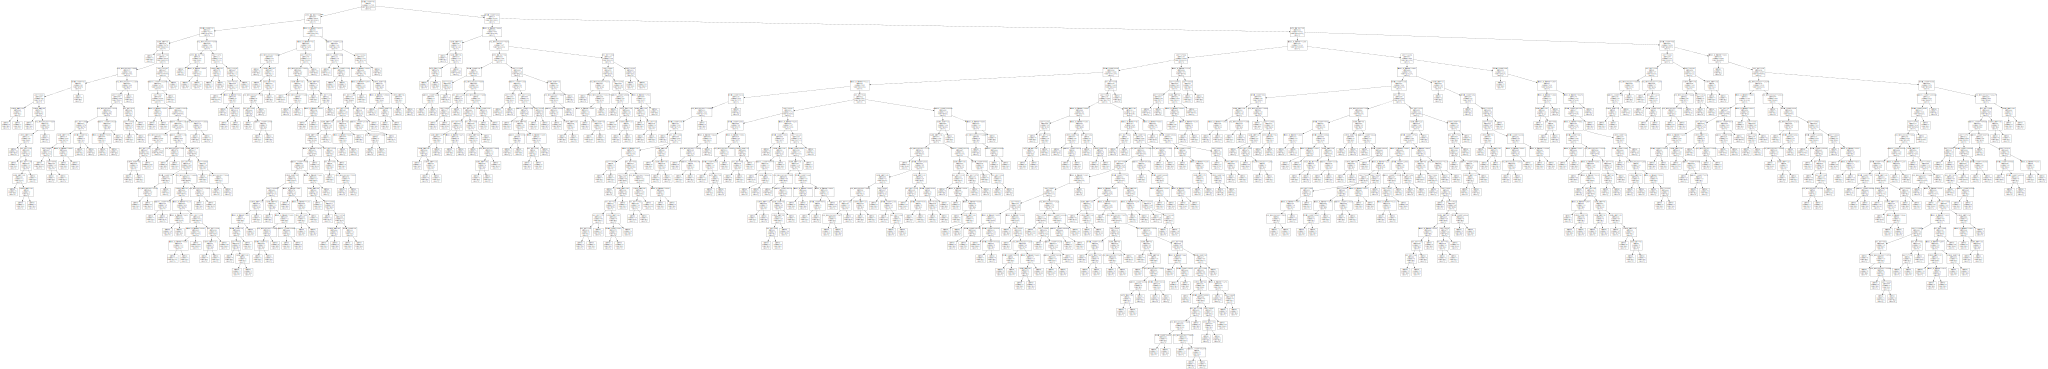

In [32]:
import graphviz 
# show the decision tree graph
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=list(usert),  
                         class_names=str(clf.classes_))  
graph = graphviz.Source(dot_data)
graph.render("decision_tree_graph")
graph

In [27]:
# make the prediction
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

pred = clf.predict(X_test)

# Getting some evaluation metrics here
print "Decision Tree report:"
print classification_report(y_test, pred)
print "Decision Tree accuracy:", accuracy_score(y_test, pred)
print "ROC score:",roc_auc_score(y_test, pred)

Decision Tree report:
             precision    recall  f1-score   support

          0       0.93      0.92      0.93      1501
          1       0.92      0.93      0.93      1431

avg / total       0.93      0.93      0.93      2932

Decision Tree accuracy: 0.9266712141882674
ROC score: 0.9267516042181988


### Navie Bayes classifier:

In [28]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
clf_nb = gnb.fit(X_train, y_train)

In [30]:
# make the decision

pred_nb = clf_nb.predict(X_test)

# Getting some evaluation metrics here
print "Navie Bayes report:"
print classification_report(y_test, pred_nb)
print "Navie Bayes accuracy:", accuracy_score(y_test, pred_nb)
print "ROC score:",roc_auc_score(y_test, pred_nb)

Navie Bayes report:
             precision    recall  f1-score   support

          0       0.63      0.99      0.77      1501
          1       0.98      0.38      0.55      1431

avg / total       0.80      0.69      0.66      2932

Navie Bayes accuracy: 0.6927012278308322
ROC score: 0.6853807221926589
